In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.path.abspath('../src/'))
sys.path.append(os.path.abspath('../'))

In [2]:
from src.central_ids import IDS
from src.utils import print_results
from src.dataset import CANDataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import numpy as np
from pathlib import Path
from sklearn.metrics import f1_score
import pickle
import torch
from flwr.common.parameter import parameters_to_ndarrays
from collections import OrderedDict
from utils import set_parameters

In [3]:
rnd = 50
ckpt_file = f'../save/FedAvg/train20000_50rnds_15epochs_lr0.0005/ckpt-rnd{rnd}.npz'
tensors = np.load(ckpt_file, allow_pickle=True)['arr_0'][()]
model = IDS(C = 2)

In [4]:
weights = parameters_to_ndarrays(tensors)
params_dict = zip(model.state_dict().keys(), weights)
state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [6]:
def evaluate(model):
    transform = None
    data_dir = '../../Data/LISA/{}/test_10000'
    car_models = ['Kia', 'Tesla', 'BMW']
    res = []
    total_labels = np.array([])
    total_preds = np.array([])
    for car_model in car_models:
        print(f'Run test on {car_model} dataset')
        test_dataset = CANDataset(root_dir=Path(data_dir.format(car_model)), is_binary=True, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, 
                                pin_memory=True, sampler=None)
        trainer = pl.Trainer(enable_checkpointing=False, logger=False, gpus=[0])
        results = trainer.predict(model, dataloaders=test_loader)
        labels = np.concatenate([x['labels'] for x in results])
        preds = np.concatenate([x['preds'] for x in results])
        f1 = f1_score(labels, preds)
        res.append(f1)
        total_labels = np.concatenate([total_labels, labels])
        total_preds = np.concatenate([total_preds, preds])
    car_models.append('Global')
    f1_global = f1_score(total_labels, total_preds)
    res.append(f1_global)
    return (car_models, res)

In [7]:
car_models, res = evaluate(model)

Run test on Kia dataset


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUs

Predicting: 0it [00:00, ?it/s]

Run test on Tesla dataset


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUs

Predicting: 0it [00:00, ?it/s]

Run test on BMW dataset


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUs

Predicting: 0it [00:00, ?it/s]

In [9]:
for name, value in zip(car_models, res):
    print(name, round(value, 4))

print('Avg ', np.mean(res))

Kia 0.7319
Tesla 0.8117
BMW 0.553
Global 0.7041
Avg  0.7001653596681899


In [5]:
import glob
files = sorted(glob.glob('../save/FedAvg/train10*/hist.pkl'))
files

['../save/FedAvg/train10000_50rnds_15epochs_lr0.0005/hist.pkl',
 '../save/FedAvg/train10000_50rnds_30epochs_lr0.0005/hist.pkl',
 '../save/FedAvg/train20000_50rnds_15epochs_lr0.0005/hist.pkl',
 '../save/FedAvg/train30000_50rnds_15epochs_lr0.0005/hist.pkl',
 '../save/FedAvg/train40000_50rnds_15epochs_lr0.0005/hist.pkl',
 '../save/FedAvg/train50000_50rnds_15epochs_lr0.0005/hist.pkl']

In [9]:
def get_f1(file_name):
    f = open(file_name, 'rb')
    hist = pickle.load(f)
    f.close()
    f1_avg = hist.metrics_centralized['f1_avg']
    f1_avg = [x[1] for x in f1_avg]
    return f1_avg

In [10]:
models_accs = list(map(get_f1, files))
models_names = [x.split('/')[-2] for x in files]
models_names

['train10000_50rnds_15epochs_lr0.0005',
 'train20000_50rnds_15epochs_lr0.0005',
 'train30000_50rnds_15epochs_lr0.0005',
 'train40000_50rnds_15epochs_lr0.0005',
 'train50000_50rnds_15epochs_lr0.0005']

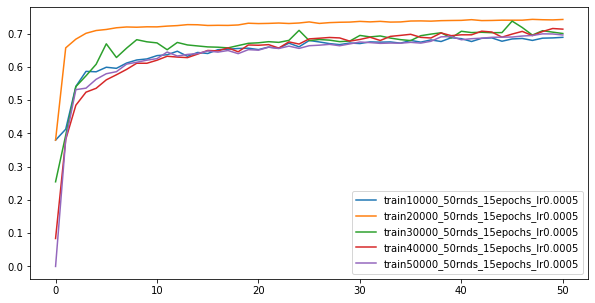

In [11]:
import matplotlib.pyplot as plt
R = 50
plt.figure(figsize=(10, 5))
for name, acc in zip(models_names, models_accs):
    plt.plot(range(R + 1), acc, label = name)
plt.legend()

In [13]:
def acc_info(acc):
    print('Accuracy at the last round: ', acc[-1])
    print('Best Accuracy: ', max(acc), ' at round ', np.argmax(acc) + 1)

In [14]:
for name, acc in zip(models_names, models_accs):
    print(name)
    acc_info(acc)

train10000_50rnds_15epochs_lr0.0005
Accuracy at the last round:  0.6887792210074161
Best Accuracy:  0.6887792210074161  at round  51
train20000_50rnds_15epochs_lr0.0005
Accuracy at the last round:  0.7424701976444413
Best Accuracy:  0.7427998722506207  at round  48
train30000_50rnds_15epochs_lr0.0005
Accuracy at the last round:  0.7002541302962407
Best Accuracy:  0.7375332313939676  at round  46
train40000_50rnds_15epochs_lr0.0005
Accuracy at the last round:  0.7133596549534156
Best Accuracy:  0.7152841437588826  at round  50
train50000_50rnds_15epochs_lr0.0005
Accuracy at the last round:  0.695767572210809
Best Accuracy:  0.6992454583470155  at round  49
